In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd

In [2]:
df = pd.read_csv('old_accident_dummy_eclo_v9.csv')

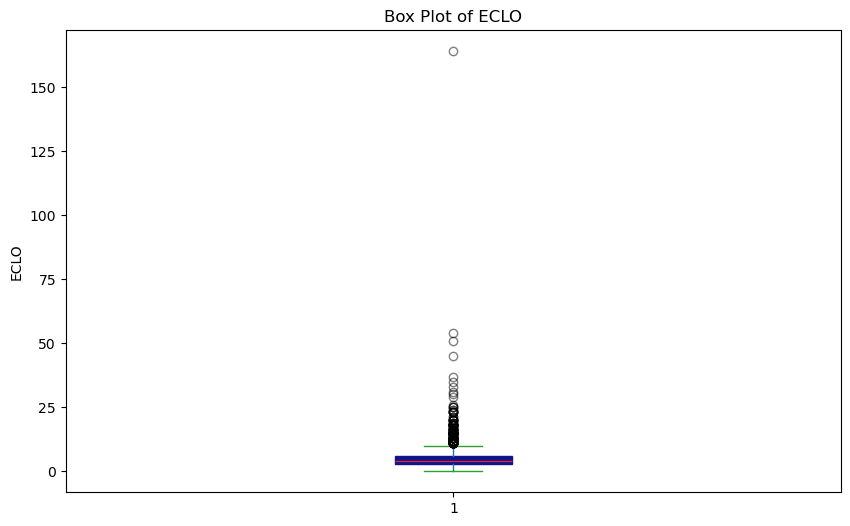

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 예시 데이터프레임 생성

# 색상 코드 설정
colors = {
    'boxes': '#0f148d',      # 박스 색상
    'whiskers': '#1f77b4',   # 수염 색상
    'caps': '#2ca02c',       # 캡 색상
    'medians': '#d62728',    # 중앙값 색상
    'fliers': '#ff7f0e'      # 이상치 색상
}

# '인명피해 심각도' 열에 대한 박스플랏 시각화
plt.figure(figsize=(10, 6))
boxplot = plt.boxplot(df['인명피해 심각도'], patch_artist=True, flierprops=dict(marker='o', color=colors['fliers'], alpha=0.5))

# 색상 코드로 색상 지정
for element in ['boxes', 'whiskers', 'caps', 'medians']:
    plt.setp(boxplot[element], color=colors[element])

# 박스 내부 색상 지정
for patch in boxplot['boxes']:
    patch.set(facecolor=colors['boxes'])

# 그래프 제목 및 축 레이블 설정
plt.title('Box Plot of ECLO')
plt.ylabel('ECLO')
plt.savefig('boxplot_before_removal.png', format='png')
plt.show()



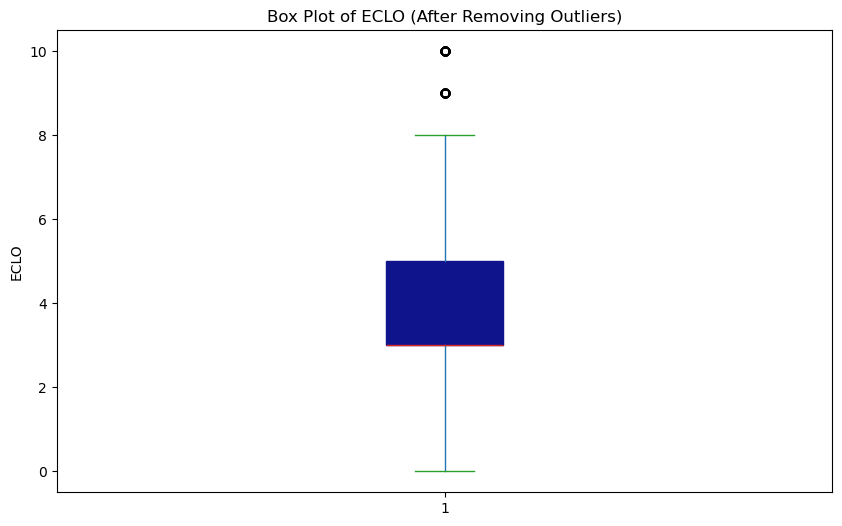

In [4]:
# IQR 계산
Q1 = df['인명피해 심각도'].quantile(0.25)
Q3 = df['인명피해 심각도'].quantile(0.75)
IQR = Q3 - Q1

# 이상치 경계 설정
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# 이상치 제거
df_cleaned = df[(df['인명피해 심각도'] >= lower_bound) & (df['인명피해 심각도'] <= upper_bound)]

# 이상치 제거 후 박스플랏 시각화
plt.figure(figsize=(10, 6))
boxplot_cleaned = plt.boxplot(df_cleaned['인명피해 심각도'], patch_artist=True, flierprops=dict(marker='o', color=colors['fliers'], alpha=0.5))

# 색상 코드로 색상 지정
for element in ['boxes', 'whiskers', 'caps', 'medians']:
    plt.setp(boxplot_cleaned[element], color=colors[element])

# 박스 내부 색상 지정
for patch in boxplot_cleaned['boxes']:
    patch.set(facecolor=colors['boxes'])

# 그래프 제목 및 축 레이블 설정
plt.title('Box Plot of ECLO (After Removing Outliers)')
plt.ylabel('ECLO')

# 그래프를 PNG 파일로 저장
plt.savefig('boxplot_after_removal.png', format='png')
plt.show()

In [6]:
df_cleaned.dtypes

요일           object
법규위반         object
가해운전자차종      object
가해운전자성별      object
가해운전자상해정도    object
              ...  
인명피해 심각도      int64
사망자수          int64
중상자수          int64
경상자수          int64
부상신고자수        int64
Length: 110, dtype: object

In [7]:
df_cleaned.to_csv('df_cleaned.csv')

In [8]:
categorical_columns = [
    '요일', '법규위반', 
    '가해운전자차종', '가해운전자성별', '가해운전자상해정도',
    '피해운전자차종', '피해운전자성별', '피해운전자상해정도',
    'cleanedAdress', '사고대분류', '사고중분류', '사고소분류', 
    '도로형태_대', '도로형태_중','노면상태','기상상태'
    #####기상상태, 노면상태는 왜 빠진거냐묘...
]

In [10]:
pd.set_option('display.max_rows', None)

print(df_cleaned.dtypes)

요일                     category
법규위반                   category
가해운전자차종                category
가해운전자성별                category
가해운전자상해정도              category
피해운전자상해정도              category
가해운전자연령                  object
피해운전자차종                category
피해운전자성별                category
피해운전자연령                  object
노면상태                   category
기상상태                   category
cleanedAdress          category
X                       float64
Y                       float64
사고연도                      int64
사고월                       int64
사고일                       int64
사고시각                      int64
사고대분류                  category
사고중분류                  category
사고소분류                  category
도로형태_대                 category
도로형태_중                 category
D.법규위반.과속                 int64
D.법규위반.교차로운행방법위반          int64
D.법규위반.기타                 int64
D.법규위반.보행자보호의무위반          int64
D.법규위반.불법유턴               int64
D.법규위반.신호위반               int64
D.법규위반.안전거리미확보            int64
D.법규위반.중

In [11]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from catboost import CatBoostRegressor
import lightgbm as lgb

In [12]:
# 범주형 변수들 (원핫인코딩 할.)
cat_features = [
    '요일', '법규위반', 
    '가해운전자차종', '가해운전자성별', '가해운전자상해정도', 
    '피해운전자차종', '피해운전자성별', '피해운전자상해정도', 
    'cleanedAdress', '사고대분류', '사고중분류', '사고소분류', 
    '도로형태_대', '도로형태_중','노면상태','기상상태'
]


In [13]:
X = df_cleaned.drop(columns=['인명피해 심각도','사망자수','부상신고자수','경상자수','중상자수']) # 레이블 제거, 독립변수들.
y = df_cleaned['인명피해 심각도'] # 종속변수

X_train_x, X_test_x, X_train_y, X_test_y = train_test_split(X, y, test_size=0.2, random_state=42)
C_train_x, C_test_x, C_train_y, C_test_y = train_test_split(X, y, test_size=0.2, random_state=42)
L_train_x, L_test_x, L_train_y, L_test_y = train_test_split(X, y, test_size=0.2, random_state=42)

## 범주형 변수, 원핫인코딩_문자열 타입 칼럼 적용
train_oh = pd.get_dummies(C_train_x[cat_features])
test_oh = pd.get_dummies(C_test_x[cat_features])

for i in train_oh.columns:
    if i not in test_oh.columns:
        test_oh[i] = 0

test_oh=test_oh[train_oh.columns] # 
display(len(test_oh.columns), len(train_oh.columns))

C_train_x.drop(cat_features, axis=1, inplace=True)
C_test_x.drop(cat_features, axis=1, inplace=True)

C_train_x=pd.concat([C_train_x, train_oh], axis=1)
C_test_x=pd.concat([C_test_x, test_oh], axis=1)

154

154

In [14]:
## 범주형 변수, 원핫인코딩_칼럼들을 모두 수치형 변수 변환
from sklearn.preprocessing import LabelEncoder

categorical_features = list(C_train_x.dtypes[C_train_x.dtypes == "object"].index)
## objct 객체가 가해자/피해자 연령 변수 정도밖에 없음.
display(categorical_features)

for i in categorical_features:
    print(i)
    le = LabelEncoder()
    le = le.fit(C_train_x[i])
    C_train_x[i] = le.transform(C_train_x[i])

    for case in np.unique(C_test_x[i]):
        if case not in le.classes_:
            print('test case is not in classes')
            le.classes_=np.append(le.classes_, case)
    C_test_x[i] = le.transform(C_test_x[i])

display(C_train_x.head())
display(C_test_x.head())


['가해운전자연령', '피해운전자연령']

가해운전자연령
피해운전자연령
test case is not in classes


,가해운전자연령,피해운전자연령,X,Y,사고연도,사고월,사고일,사고시각,D.법규위반.과속,D.법규위반.교차로운행방법위반,...,노면상태_서리/결빙,노면상태_습기,노면상태_적설,노면상태_젖음/습기,기상상태_기타,기상상태_눈,기상상태_맑음,기상상태_비,기상상태_안개,기상상태_흐림
2818,6,36,127.144382,36.809389,2023,4,18,20,0,0,...,False,False,False,False,False,False,True,False,False,False
2927,2,51,127.123154,36.801086,2023,7,24,14,0,0,...,False,False,False,False,False,False,True,False,False,False
292,0,43,127.124344,36.930865,2011,6,30,12,0,0,...,False,False,False,False,False,False,True,False,False,False
1511,3,71,127.151968,36.799544,2019,4,10,10,0,0,...,False,False,False,False,False,False,True,False,False,False
2524,20,0,127.086917,36.671026,2022,10,12,10,0,0,...,False,False,False,False,False,False,True,False,False,False


,가해운전자연령,피해운전자연령,X,Y,사고연도,사고월,사고일,사고시각,D.법규위반.과속,D.법규위반.교차로운행방법위반,...,노면상태_서리/결빙,노면상태_습기,노면상태_적설,노면상태_젖음/습기,기상상태_기타,기상상태_눈,기상상태_맑음,기상상태_비,기상상태_안개,기상상태_흐림
870,20,21,127.170560,36.797062,2016,4,19,11,0,0,...,False,False,False,False,False,False,True,False,False,False
278,4,27,127.123154,36.801086,2011,4,11,9,0,0,...,False,False,False,False,False,False,True,False,False,False
2687,0,19,127.123154,36.801086,2023,3,20,19,0,0,...,False,False,False,False,False,False,True,False,False,False
2670,4,43,127.128066,36.779291,2023,4,26,14,0,1,...,False,False,False,False,False,False,True,False,False,False
2343,14,52,127.191434,36.876896,2022,3,3,7,0,0,...,False,False,False,False,False,False,True,False,False,False


In [15]:
C_train_x.columns

Index(['가해운전자연령', '피해운전자연령', 'X', 'Y', '사고연도', '사고월', '사고일', '사고시각',
       'D.법규위반.과속', 'D.법규위반.교차로운행방법위반',
       ...
       '노면상태_서리/결빙', '노면상태_습기', '노면상태_적설', '노면상태_젖음/습기', '기상상태_기타', '기상상태_눈',
       '기상상태_맑음', '기상상태_비', '기상상태_안개', '기상상태_흐림'],
      dtype='object', length=243)

In [16]:
# Model Train & Prediction
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping
from catboost import CatBoostRegressor
import optuna

from sklearn.metrics import mean_squared_log_error as msle
from sklearn.model_selection import train_test_split

In [18]:
# XGBoost
def xgb_modeling(X_train, y_train, X_valid, y_valid):
  def objective(trial):
    params = {
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.1),  # 최소값이 0보다 큼
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_loguniform('gamma', 0.01, 1.0),  # 최소값이 0보다 큼
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.01, 1.0),  # 최소값이 0보다 큼
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.01, 1.0),  # 최소값이 0보다 큼
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'n_estimators': trial.suggest_int('n_estimators', 300, 1000),
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
    }

    model = XGBRegressor(**params, random_state=42, n_jobs=-1, objective='reg:squaredlogerror')
    bst_xgb = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmsle', early_stopping_rounds=100, verbose=False)

    preds = bst_xgb.predict(X_valid)
    preds = np.maximum(preds, 0)  # negative value 방지
    loss = msle(y_valid, preds)

    return np.sqrt(loss)

  study_xgb = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=100))
  study_xgb.optimize(objective, n_trials=30, show_progress_bar=True)

  xgb_reg = XGBRegressor(**study_xgb.best_params, random_state=42, n_jobs=-1, objective='reg:squaredlogerror')
  xgb_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmsle', early_stopping_rounds=100, verbose=False)

  return xgb_reg, study_xgb

# LightGBM
def lgbm_modeling(X_train, y_train, X_valid, y_valid):
  def objective(trial):
    param = {
        'objective': 'regression',
        'metric': 'rmse',
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.7, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.0001, 1.0),  # 최소값이 0보다 큼
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.0001, 10.0),  # 최소값이 0보다 큼
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_loguniform("learning_rate", 1e-5, 1e-2),  # 최소값이 0보다 큼
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
    }

    model = LGBMRegressor(**param, random_state=42, n_jobs=-1)
    bst_lgbm = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])

    preds = bst_lgbm.predict(X_valid)
    preds = np.maximum(preds, 0)
    loss = msle(y_valid, preds)

    return np.sqrt(loss)

  study_lgbm = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=100))
  study_lgbm.optimize(objective, n_trials=30, show_progress_bar=True)

  lgbm_reg = LGBMRegressor(**study_lgbm.best_params, random_state=42, n_jobs=-1)
  lgbm_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmse', callbacks=[early_stopping(stopping_rounds=100)])

  return lgbm_reg, study_lgbm

# CatBoost
def cat_modeling(X_train, y_train, X_valid, y_valid):
  def objective(trial):
    param = {
        'iterations': trial.suggest_int("iterations", 1000, 20000),
        'od_wait': trial.suggest_int('od_wait', 500, 2300),
        'learning_rate': trial.suggest_uniform('learning_rate', 0.01, 1),  # 최소값이 0보다 큼
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 100),  # 최소값이 0보다 큼
        'subsample': trial.suggest_uniform('subsample', 0.5, 1.0),
        'depth': trial.suggest_int('depth', 3, 15),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 30),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.0),  # 최소값이 0보다 큼
        'colsample_bylevel': trial.suggest_uniform('colsample_bylevel', 0.4, 1.0),
    }

    model = CatBoostRegressor(**param, random_state=42, silent=True)
    bst_cat = model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)

    preds = bst_cat.predict(X_valid)
    preds = np.maximum(preds, 0)
    loss = msle(y_valid, preds)

    return np.sqrt(loss)

  study_cat = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=100))
  study_cat.optimize(objective, n_trials=30, show_progress_bar=True)

  cat_reg = CatBoostRegressor(**study_cat.best_params, random_state=42)
  cat_reg.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, verbose=False)

  return cat_reg, study_cat

In [ ]:
# Ensamble
X_train,X_valid,y_train,y_valid = train_test_split(C_train_x,C_train_y,random_state=42,shuffle=True,test_size=0.2)

### 타겟변수 왜도 첨도 조정>>log 처리
temp_train_y = np.log1p(y_train)
temp_valid_y = np.log1p(y_valid)

cat,study_cat = cat_modeling(X_train,temp_train_y,X_valid,temp_valid_y)
xgb,study_xgb = xgb_modeling(X_train,temp_train_y,X_valid,temp_valid_y)
lgbm,study_lgbm = lgbm_modeling(X_train,temp_train_y,X_valid,temp_valid_y)

cat_prediction = cat.predict(C_test_x)
xgb_prediction = xgb.predict(C_test_x)
lgbm_prediction = lgbm.predict(C_test_x)

cat_prediction = np.expm1(cat_prediction)
xgb_prediction = np.expm1(xgb_prediction)
lgbm_prediction = np.expm1(lgbm_prediction)


In [20]:
import numpy as np
from scipy.optimize import minimize

# 실제값 (로그 변환을 되돌린 검증 데이터의 타겟 값)
y_true = np.expm1(temp_valid_y)

# 각 모델의 검증 데이터에 대한 예측값 (로그 변환을 되돌림)
cat_valid_preds = np.expm1(cat.predict(X_valid))
xgb_valid_preds = np.expm1(xgb.predict(X_valid))
lgbm_valid_preds = np.expm1(lgbm.predict(X_valid))

# 예측값 배열
y_preds = np.array([
    cat_valid_preds,
    xgb_valid_preds,
    lgbm_valid_preds
])

# 초기 가중치 설정 (예: 동일 가중치)
initial_weights = np.array([1/3, 1/3, 1/3])

# MSE 계산 함수 정의
def mse(weights):
    weighted_preds = np.dot(weights, y_preds)
    return np.mean((y_true - weighted_preds) ** 2)

# 가중치 합이 1이 되도록 제약 조건 설정
constraints = (
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # 가중치 합이 1
    {'type': 'ineq', 'fun': lambda w: w[2] - 0.01}  # LGBM의 가중치가 0.01 이상
)

# 가중치 범위 설정 (0과 1 사이)
bounds = [(0, 1) for _ in range(len(initial_weights))]

# 최적화 수행
optimized_result = minimize(mse, initial_weights, constraints=constraints, bounds=bounds)

# 최적화된 가중치 출력
optimized_weights = optimized_result.x
print("최적화된 가중치:", optimized_weights)

# 최적화된 가중치를 사용하여 최종 예측값 계산
final_predictions = np.dot(optimized_weights, np.array([cat_prediction, xgb_prediction, lgbm_prediction]))

최적화된 가중치: [0.98698774 0.         0.01301226]


In [ ]:
# ## XGB가 과적합 위험이 커서 가중치를 제일 낮게 주는 경향

prediction = cat_prediction*0.98698774+ xgb_prediction*0 + lgbm_prediction*0.01301226
prediction = np.clip(prediction,0,164)
# prediction = cat_prediction
prediction

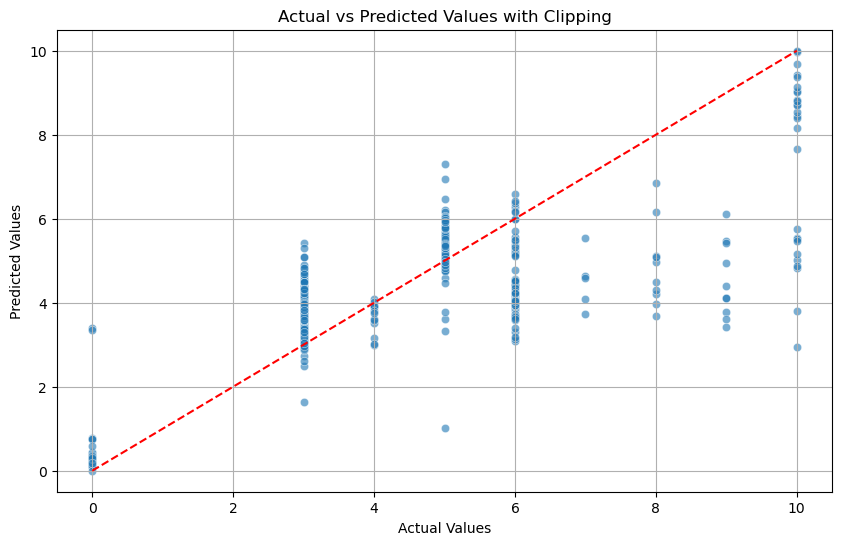

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 예측 결과와 실제 결과를 비교 (로그 변환한 데이터의 역변환값으로 가정)
true_values = np.expm1(temp_valid_y)  # 검증 데이터의 실제 값

# 각 모델의 예측값에 가중치를 적용한 최종 예측값
predicted_values = np.expm1(cat.predict(X_valid)) * 0.98698774+ + \
                   np.expm1(xgb.predict(X_valid)) * 0 + \
                   np.expm1(lgbm.predict(X_valid)) * 0.01301226

# 예측값을 실제값의 범위로 클리핑
clipped_predicted_values = np.clip(predicted_values, true_values.min(), true_values.max())

plt.figure(figsize=(10, 6))
sns.scatterplot(x=true_values, y=clipped_predicted_values, alpha=0.6)
plt.plot([true_values.min(), true_values.max()], [true_values.min(), true_values.max()], 'r--')  # 대각선 라인
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values with Clipping')
plt.grid(True)

plt.savefig('actualVSpredicted_clipped.png')
plt.show()

C:\Users\a0i01\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


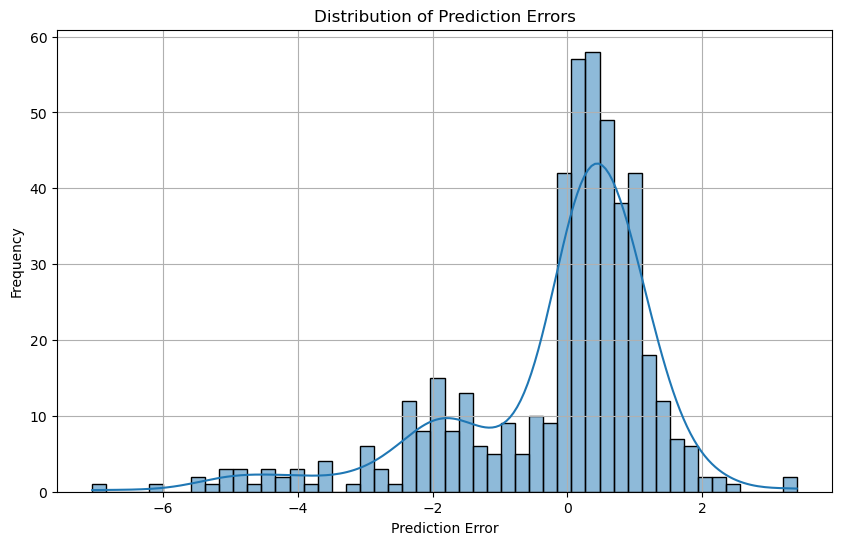

In [23]:
# 오차분포 시각화
errors = clipped_predicted_values - true_values

plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50, kde=True)
plt.xlabel('Prediction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True)
plt.savefig('Distribution of Prediction Errors.png')
plt.show()

C:\Users\a0i01\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\a0i01\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\a0i01\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


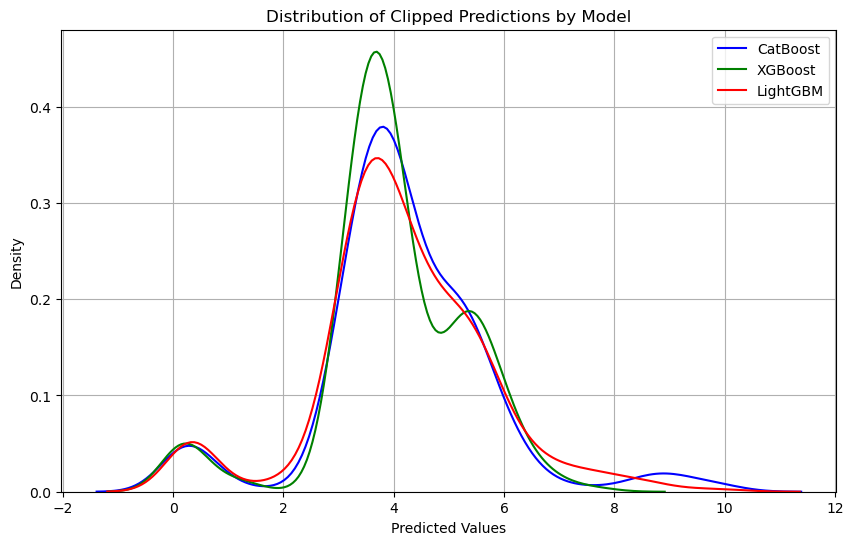

In [24]:
import seaborn as sns
import numpy as np

# 예측 결과와 실제 결과를 비교 (로그 변환한 데이터의 역변환값으로 가정)
true_values = np.expm1(temp_valid_y)  # 검증 데이터의 실제 값

# 각 모델의 예측값에 가중치를 적용한 최종 예측값
cat_preds = np.expm1(cat.predict(X_valid))
xgb_preds = np.expm1(xgb.predict(X_valid))
lgbm_preds = np.expm1(lgbm.predict(X_valid))

# 예측값을 실제값의 범위로 클리핑
cat_preds_clipped = np.clip(cat_preds, true_values.min(), true_values.max())
xgb_preds_clipped = np.clip(xgb_preds, true_values.min(), true_values.max())
lgbm_preds_clipped = np.clip(lgbm_preds, true_values.min(), true_values.max())

# 클리핑된 예측값 분포 시각화
plt.figure(figsize=(10, 6))
sns.kdeplot(cat_preds_clipped, label='CatBoost', color='blue')
sns.kdeplot(xgb_preds_clipped, label='XGBoost', color='green')
sns.kdeplot(lgbm_preds_clipped, label='LightGBM', color='red')
plt.xlabel('Predicted Values')
plt.ylabel('Density')
plt.title('Distribution of Clipped Predictions by Model')
plt.legend()
plt.grid(True)
plt.savefig('Distribution_of_Clipped_Predictions_by_Model.png')
plt.show()

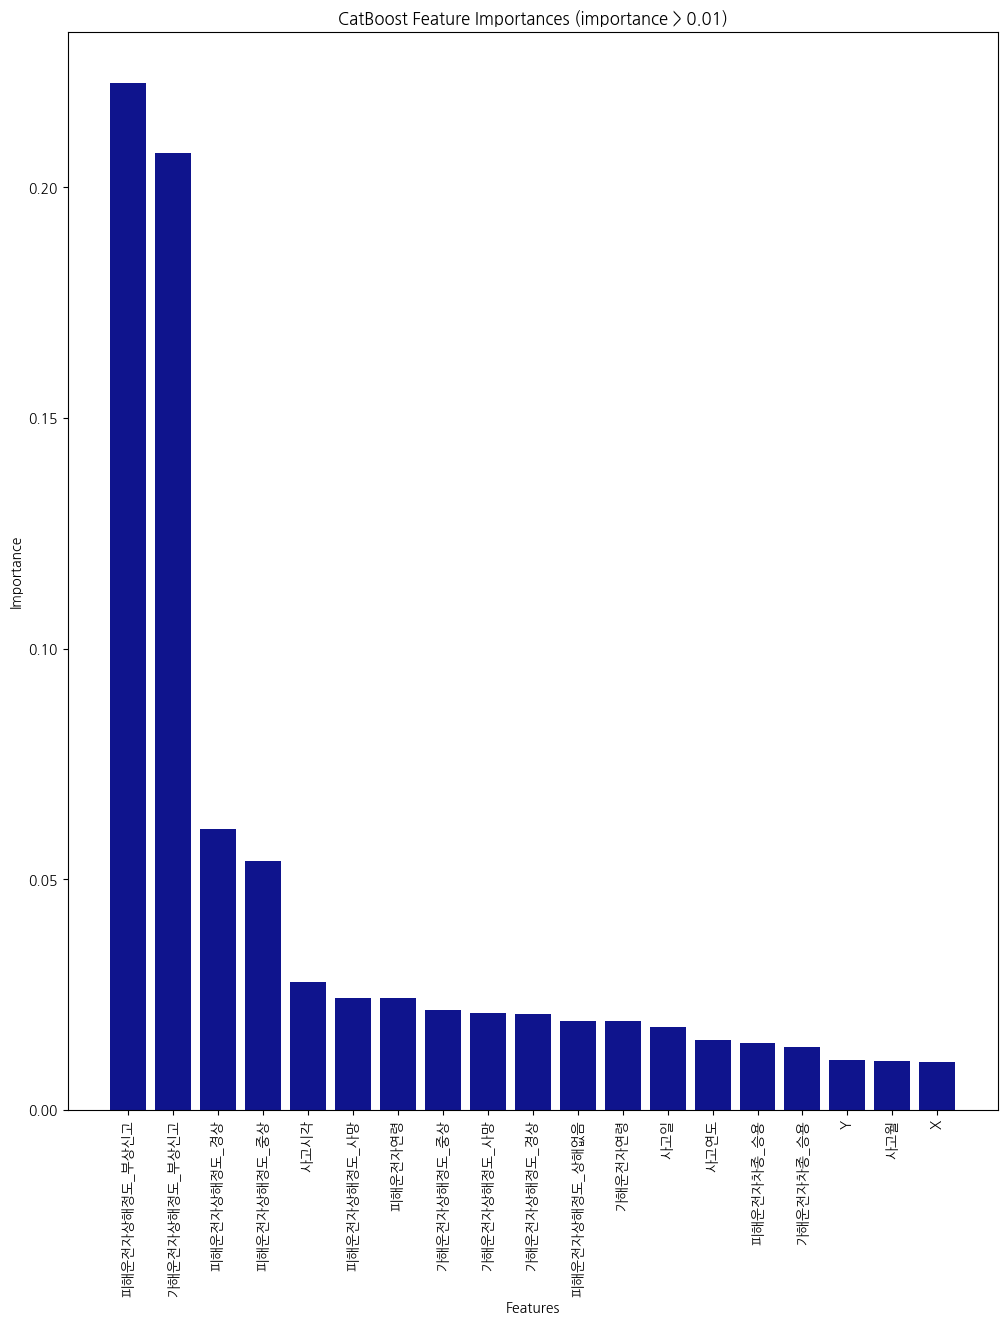

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature importances from CatBoost model
cat_importances = cat.get_feature_importance()
feature_names = np.array(X_train.columns)

# Normalize the importances
cat_importances_normalized = cat_importances / np.sum(cat_importances)

# Filter out features with importance <= 0.01
important_indices = cat_importances_normalized > 0.01

# Apply the filter
filtered_importances = cat_importances_normalized[important_indices]
filtered_feature_names = feature_names[important_indices]

# Sort features by importance
sorted_indices = np.argsort(filtered_importances)[::-1]

# 폰트 설정
plt.rcParams['font.family'] = 'NanumGothic'  # 한글 폰트 설정, 사용하려는 폰트로 변경 가능
plt.rcParams['axes.unicode_minus'] = False   # 음수 기호 제대로 표시되도록 설정

# Plot feature importances
plt.figure(figsize=(12, 14))
plt.title("CatBoost Feature Importances (importance > 0.01)")
plt.bar(range(len(filtered_importances[sorted_indices])), filtered_importances[sorted_indices], align="center", color='#0f148d')
plt.xticks(range(len(filtered_importances[sorted_indices])), filtered_feature_names[sorted_indices], rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig('Importance.png')
plt.show()

In [ ]:
dummy_columns = ['cleanedAdress_충청남도 천안시 동남구 광덕면',
                 'cleanedAdress_충청남도 천안시 동남구 구룡동',
                 'cleanedAdress_충청남도 천안시 동남구 구성동',
                 'cleanedAdress_충청남도 천안시 동남구 다가동',
                 'cleanedAdress_충청남도 천안시 동남구 대흥동',
                 'cleanedAdress_충청남도 천안시 동남구 동면',
                 'cleanedAdress_충청남도 천안시 동남구 목천읍',
                 'cleanedAdress_충청남도 천안시 동남구 문화동',
                 'cleanedAdress_충청남도 천안시 동남구 병천면',
                 'cleanedAdress_충청남도 천안시 동남구 봉명동',    
                 'cleanedAdress_충청남도 천안시 동남구 북면',
                 'cleanedAdress_충청남도 천안시 동남구 사직동',    
                 'cleanedAdress_충청남도 천안시 동남구 삼룡동',
                 'cleanedAdress_충청남도 천안시 동남구 성남면',
                 'cleanedAdress_충청남도 천안시 동남구 성황동',
                 'cleanedAdress_충청남도 천안시 동남구 수신면',
                 'cleanedAdress_충청남도 천안시 동남구 신방동',
                 'cleanedAdress_충청남도 천안시 동남구 신부동',
                 'cleanedAdress_충청남도 천안시 동남구 쌍용동',
                 'cleanedAdress_충청남도 천안시 동남구 안서동',
                 'cleanedAdress_충청남도 천안시 동남구 영성동',
                 'cleanedAdress_충청남도 천안시 동남구 오룡동',
                 'cleanedAdress_충청남도 천안시 동남구 용곡동',
                 'cleanedAdress_충청남도 천안시 동남구 원성동',
                 'cleanedAdress_충청남도 천안시 동남구 유량동',    
                 'cleanedAdress_충청남도 천안시 동남구 청당동',
                 'cleanedAdress_충청남도 천안시 동남구 청수동',
                 'cleanedAdress_충청남도 천안시 동남구 풍세면',    
                 'cleanedAdress_충청남도 천안시 서북구',
                 'cleanedAdress_충청남도 천안시 서북구 두정동',
                 'cleanedAdress_충청남도 천안시 서북구 백석동',
                 'cleanedAdress_충청남도 천안시 서북구 부대동',    
                 'cleanedAdress_충청남도 천안시 서북구 불당동',    
                 'cleanedAdress_충청남도 천안시 서북구 성거읍',
                 'cleanedAdress_충청남도 천안시 서북구 성성동',    
                 'cleanedAdress_충청남도 천안시 서북구 성정동',
                 'cleanedAdress_충청남도 천안시 서북구 성환읍',
                 'cleanedAdress_충청남도 천안시 서북구 신당동',
                 'cleanedAdress_충청남도 천안시 서북구 쌍용동',
                 'cleanedAdress_충청남도 천안시 서북구 업성동',
                 'cleanedAdress_충청남도 천안시 서북구 와촌동',
                 'cleanedAdress_충청남도 천안시 서북구 입장면',
                 'cleanedAdress_충청남도 천안시 서북구 직산읍',
                 'cleanedAdress_충청남도 천안시 서북구 차암동'
]

# 더미변수에서 지역이름 추출
def extract_region(row):
    for col in dummy_columns:
        if row[col] == 1:
            return col.replace('cleanedAdress_', '')  # 'cleanedAdress_' 접두사를 제거하여 지역 이름 추출
    return 'Unknown'  # 해당되지 않는 경우

# 지역 이름을 저장할 열 추가
C_test_x['region'] = C_test_x.apply(extract_region, axis=1)   

# 예측값 생성 및 클리핑
prediction = cat_prediction * 0.98698907 + xgb_prediction * 0 + lgbm_prediction * 0.01301093
prediction = np.clip(prediction, 0, 160)

# 예측값 길이가 C_test_x와 맞지 않는 경우 처리
if len(prediction) != len(C_test_x):
    raise ValueError(f"Prediction array length {len(prediction)} does not match C_test_x length {len(C_test_x)}")

# 결과 데이터프레임 생성
results_df = pd.DataFrame({
    'region': C_test_x['region'],
    'predicted_accidents': prediction
})

results_df

In [ ]:
# 지역별 예측 사고 건수 합산
results_df['sub_region'] = results_df['region'].apply(lambda x: x.split()[-1])

# 결과 확인
print(results_df)
results_df.to_csv('region.csv')

In [ ]:
predicted_acc_region = pd.read_csv('predicted_acc_region.csv')
predicted_acc_region

In [35]:
# print("MSE_xgb", mean_squared_error(y_test_x, y_pred_x))
# print("R2_xgb", r2_score(y_test_x, y_pred_x))
# print("MSE_cat", mean_squared_error(y_test_c, y_pred_c))
# print("R2_cat", r2_score(y_test_c, y_pred_c))

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# 검증 데이터에 대한 예측 (각 모델에 대해 log 변환된 타겟을 사용했으므로, 역변환 필요)
cat_valid_pred = cat.predict(X_valid)
xgb_valid_pred = xgb.predict(X_valid)
lgbm_valid_pred = lgbm.predict(X_valid)

# 역변환
cat_valid_pred = np.expm1(cat_valid_pred)
xgb_valid_pred = np.expm1(xgb_valid_pred)
lgbm_valid_pred = np.expm1(lgbm_valid_pred)

# 실제 값의 역변환
y_valid_actual = np.expm1(temp_valid_y)

# 개별 모델에 대한 평가지표 계산
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

cat_metrics = evaluate_model(y_valid_actual, cat_valid_pred)
xgb_metrics = evaluate_model(y_valid_actual, xgb_valid_pred)
lgbm_metrics = evaluate_model(y_valid_actual, lgbm_valid_pred)

# 결과 출력
print("CatBoost Metrics")
print(f"MAE: {cat_metrics[0]:.4f}, MSE: {cat_metrics[1]:.4f}, RMSE: {cat_metrics[2]:.4f}, R²: {cat_metrics[3]:.4f}")

print("\nXGBoost Metrics")
print(f"MAE: {xgb_metrics[0]:.4f}, MSE: {xgb_metrics[1]:.4f}, RMSE: {xgb_metrics[2]:.4f}, R²: {xgb_metrics[3]:.4f}")

print("\nLightGBM Metrics")
print(f"MAE: {lgbm_metrics[0]:.4f}, MSE: {lgbm_metrics[1]:.4f}, RMSE: {lgbm_metrics[2]:.4f}, R²: {lgbm_metrics[3]:.4f}")

CatBoost Metrics
MAE: 1.0582, MSE: 2.3671, RMSE: 1.5385, R²: 0.5427

XGBoost Metrics
MAE: 1.1354, MSE: 2.8299, RMSE: 1.6822, R²: 0.4533

LightGBM Metrics
MAE: 1.1986, MSE: 3.0469, RMSE: 1.7455, R²: 0.4113


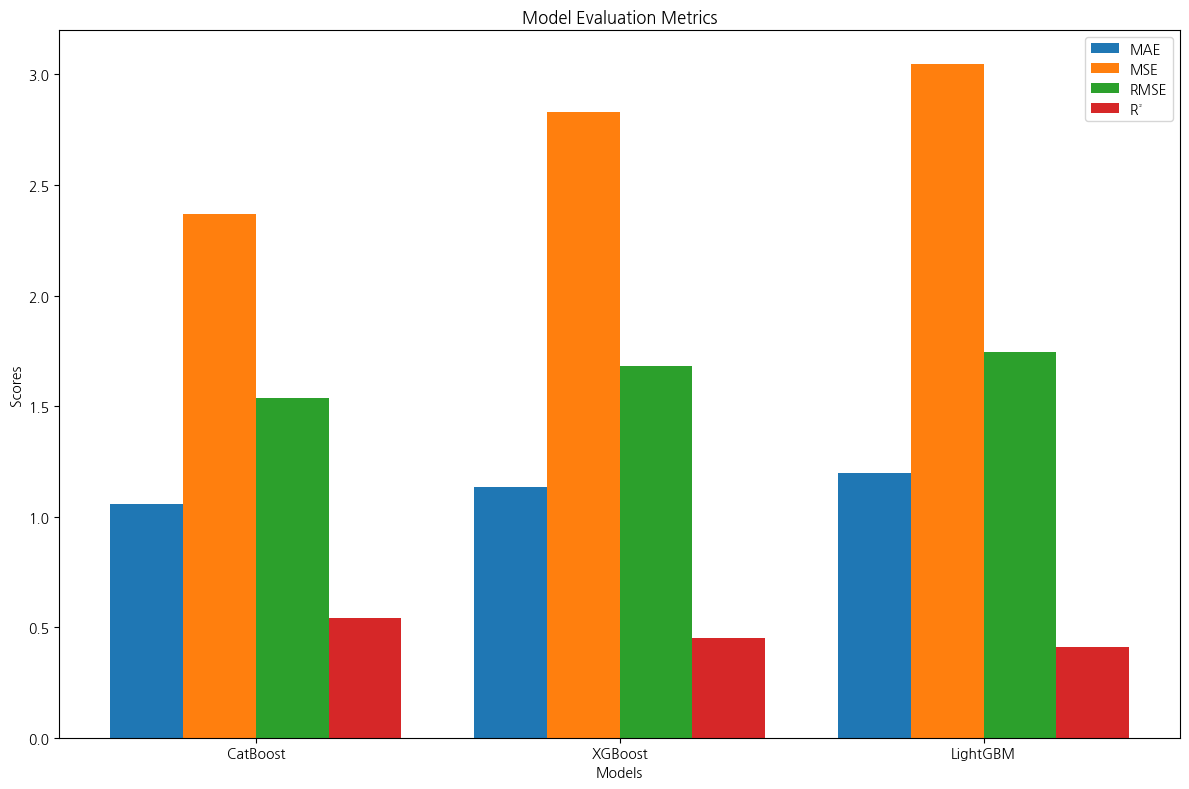

In [36]:
import matplotlib.pyplot as plt
import numpy as np

# 모델 성능 지표
metrics = {
    'CatBoost': cat_metrics,
    'XGBoost': xgb_metrics,
    'LightGBM': lgbm_metrics
}

# 지표 이름
metric_names = ['MAE', 'MSE', 'RMSE', 'R²']
metric_values = {name: [] for name in metric_names}

# 각 모델에 대한 지표 값을 리스트에 저장
for model, values in metrics.items():
    for name, value in zip(metric_names, values):
        metric_values[name].append(value)

# 시각화
x = np.arange(len(metrics))  # 모델의 개수
width = 0.2  # 막대의 너비

fig, ax = plt.subplots(figsize=(12, 8))

# 각 지표에 대해 막대 그래프 그리기
for i, metric_name in enumerate(metric_names):
    ax.bar(x + i * width, metric_values[metric_name], width, label=metric_name)

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Evaluation Metrics')
ax.set_xticks(x + width * (len(metric_names) - 1) / 2)
ax.set_xticklabels(metrics.keys())
ax.legend()

plt.tight_layout()
plt.show()